In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ler.rates import LeR
from ler.utils import get_param_from_json, append_json

In [3]:
ler = LeR(event_type="BNS", verbose=False)

In [5]:
ler.batch_size = 100000
mu_arr = get_param_from_json("./ler_data/magnifications.json")["magnifications"]
while len(mu_arr)<50000:
    lensed_params = ler.lensed_cbc_statistics(size=100000)
    mu = np.log10(abs(lensed_params["magnifications"].flatten()))
    idx = (mu > 2) & (mu < 5)
    mu = mu[idx]
    print('len(mu) at this batch: ',len(mu))
    mu_dict = {"magnifications": mu}
    mu_arr = append_json("./ler_data/magnifications.json", mu_dict)["magnifications"]
    print(f'len(mu_arr) total: {len(mu_arr)} \n')

50021


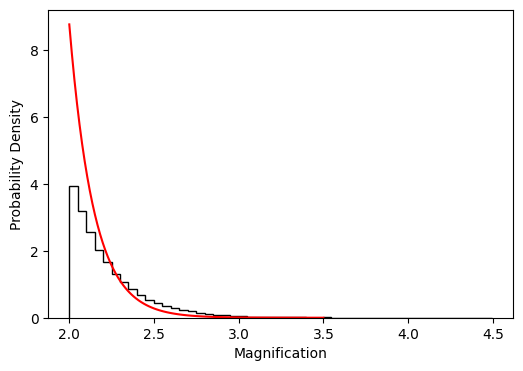

In [65]:
mu = get_param_from_json("./ler_data/magnifications.json")["magnifications"]
print(len(mu))
log10_mu_arr = np.linspace(2, 3.5, 100)
mu_arr = 10**log10_mu_arr
#pdf = log10_mu_arr**(-2)+8
pdf = 8*mu_arr**-3*6.9**7.2

# plot the magnification distribution
plt.figure(figsize=(6, 4))
plt.hist(mu, bins=50, density=True, histtype="step", color="black")
plt.plot(log10_mu_arr, pdf, color="red", label=r"$\propto \mu^{-2}$")
plt.xlabel("Magnification")
plt.ylabel("Probability Density")
#plt.title("Magnification Distribution")
plt.show()

## Curve fitting

In [56]:
# find number of point in each bin
n, bins = np.histogram(mu[mu<3.5], bins=100)
# find corresponding mu values
log10_mu = 0.5 * (bins[1:] + bins[:-1])
# bin width
dlog10_mu = log10_mu[1] - log10_mu[0]
# log10_mu

In [60]:
# fit a power law to the kde, y = a*log10(x)**-3+ b
from scipy.optimize import curve_fit
# def power_law(x, a, b):
#     return a * np.log10(x)**-3 + b

# mu = 10**log10_mu
# popt, pcov = curve_fit(power_law, mu, n, p0=[1, 1])
# popt
def power_law(x, a):
    return a * np.log10(x)**-3

mu = 10**log10_mu
popt, pcov = curve_fit(power_law, mu, n, p0=[1])
popt

array([12144.50409901])

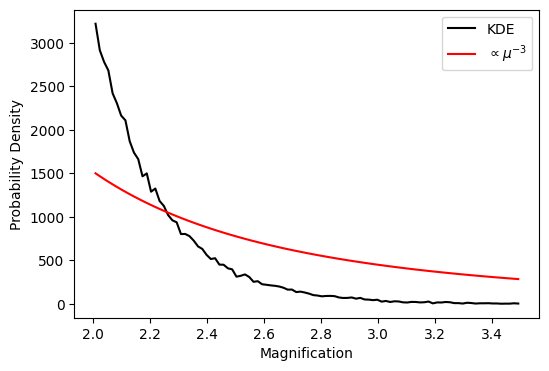

In [61]:
# plot the kde and the power law fit
a = popt[0]
# b = popt[1]
plt.figure(figsize=(6, 4))
plt.plot(log10_mu, n, color="black", label="KDE")
plt.plot(log10_mu, a*log10_mu**-3, color="red", label=r"$\propto \mu^{-3}$")
plt.xlabel("Magnification")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

## Renske's parameters

In [66]:
# initialize LeR
ler = LeR(
    npool=8,
    verbose=False,
    # SNR related
    sampling_frequency =  2048,
    waveform_approximant =  'IMRPhenomD',
    minimum_frequency =  20.0,
    snr_type =  'interpolation',
    ifos =  ['L1', 'H1', 'V1'],
    # GW related
    source_priors= {
        'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 
        'source_frame_masses': 'binary_masses_BBH_popI_II_powerlaw_gaussian', 
        'zs': 'sample_source_redshift', 
        'geocent_time': 'sampler_uniform', 
        'ra': 'sampler_uniform', 
        'dec': 'sampler_cosine', 
        'phase': 'sampler_uniform', 
        'psi': 'sampler_uniform', 
        'theta_jn': 'sampler_sine'
        },      
    source_priors_params= {
        'merger_rate_density': {'R0': 2.39e-08, 'b2': 1.6, 'b3': 2.1, 'b4': 30.}, 
        'source_frame_masses': {'mminbh': 4.59, 'mmaxbh': 86.22, 'alpha': 2.63, 'mu_g': 33.07, 'sigma_g': 5.69, 'lambda_peak': 0.10, 'delta_m': 4.82, 'beta': 1.26}, 
        'zs': None, 
        'geocent_time': {'min_': 1238166018, 'max_': 1269702018}, 
        'ra': {'min_': 0.0, 'max_': 6.283185307179586}, 
        'dec': None, 
        'phase': {'min_': 0.0, 'max_': 6.283185307179586}, 
        'psi': {'min_': 0.0, 'max_': 3.141592653589793}, 
        'theta_jn': None
        },
    spin_zero= True,
    spin_precession= False,
    # lens related
    lens_type =  'epl_galaxy',
    lens_functions =  {
        'strong_lensing_condition': 'rjs_with_cross_section_SIS', 
        'optical_depth': 'optical_depth_SIS_haris', 
        'param_sampler_type': 'sample_all_routine',
        },
    lens_priors =  {
        'source_redshift_sl': 'strongly_lensed_source_redshifts', 
        'lens_redshift': 'lens_redshift_SDSS_catalogue', 
        'velocity_dispersion': 'velocity_dispersion_gengamma', 
        'axis_ratio': 'axis_ratio_rayleigh', 
        'axis_rotation_angle': 'axis_rotation_angle_uniform', 
        'shear': 'shear_norm', 
        'mass_density_spectral_index': 'mass_density_spectral_index_normal', 
        'source_parameters': 'sample_gw_parameters',
        },
    lens_priors_params =  {
        'source_redshift_sl': None, 
        'lens_redshift': None, 
        'velocity_dispersion': {'a':2.32 / 2.67, 'c':2.67}, 
        'axis_ratio': {'q_min': 0.2, 'q_max': 1.0}, 
        'axis_rotation_angle': {'phi_min': 0.0, 'phi_max': 2*np.pi}, 
        'shear': {'scale': 0.05}, 
        'mass_density_spectral_index': {'mean': 2.0, 'std': 0.2}, 'source_parameters': None
    },
    # image related
    n_min_images =  2,
    n_max_images =  4,
    lens_model_list =  ['EPL_NUMBA', 'SHEAR'],
)

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_0.pickle
merger_rate_density interpolator will be generated at ./interpolator_pickle/merger_rate_density/merger_rate_density_10.pickle
z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_gengamma interpolator will be generated at ./interpolator_pickle/velocity_dispersion_gengamma/v

interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [02:53<00:00,  3.47s/it]


 LeR set up params:
npool =  4
z_min =  0.0
z_max =  10.0
event_type = 'BBH'
size =  100000
batch_size =  50000
cosmology =  LambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Ode0=0.7, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)
snr_finder =  <bound method GWSNR.snr of <gwsnr.gwsnr.GWSNR object at 0x33d7bc340>>
json_file_names =  {'ler_params': 'ler_params.json', 'unlensed_param': 'unlensed_param.json', 'unlensed_param_detectable': 'unlensed_param_detectable.json', 'lensed_param': 'lensed_param.json', 'lensed_param_detectable': 'lensed_param_detectable.json'}
interpolator_directory =  ./interpolator_pickle
ler_directory =  ./ler_data

 LeR also takes CBCSourceParameterDistribution params as kwargs, as follows:
source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 'source_frame_masses': 'binary_masses_BBH_popI_II_powerlaw_gaussian', 'zs': 'sample_source_redshift', 'geocent_time': 'sampler_uniform', 'ra': 'sampler_uniform', 'dec': 'sampler_cosine', 'phase': 'sample

In [78]:
unlensed_params = ler.selecting_n_unlensed_detectable_events(
    size=100000, 
    snr_threshold=8.0,
    batch_size=200000,
    resume=True,
    trim_to_size=False,
    output_jsonfile='unlensed_params_wierda_bbh.json',
    meta_data_file="meta_unlensed_wierda_bbh.json",
    )

collected number of detectable events =  80958
collected number of detectable events =  82996
total number of events =  8200000
total unlensed rate (yr^-1): 832.2557704036197
collected number of detectable events =  85006
total number of events =  8400000
total unlensed rate (yr^-1): 832.1158606542525
collected number of detectable events =  87000
total number of events =  8600000
total unlensed rate (yr^-1): 831.8294782011662
collected number of detectable events =  89024
total number of events =  8800000
total unlensed rate (yr^-1): 831.8364318436172
collected number of detectable events =  90978
total number of events =  9000000
total unlensed rate (yr^-1): 831.2035344865352
collected number of detectable events =  93040
total number of events =  9200000
total unlensed rate (yr^-1): 831.5634257943452
collected number of detectable events =  95002
total number of events =  9400000
total unlensed rate (yr^-1): 831.0332491530665
collected number of detectable events =  96980
total numb

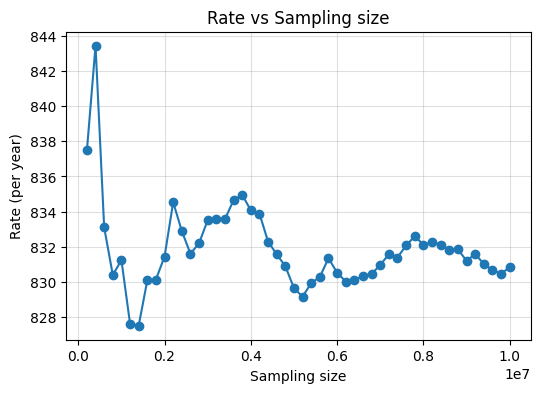

In [79]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_wierda_bbh.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [80]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.6e7)[0]
# take average 
gw_rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', gw_rate_unlensed)

Unlensed GRB Rate (per year) = 831.2666802573718


In [81]:
lensed_params = ler.selecting_n_lensed_detectable_events(
    size=5000,
    snr_threshold=[8.0,8.0],
    num_img=[1,1],
    batch_size=200000,
    resume=False,
    output_jsonfile='lensed_params_wierda_bbh.json',
    meta_data_file="meta_lensed_wierda_bbh.json",
    )

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


collected number of detectable events =  1495
total number of events =  200000
total lensed rate (yr^-1): 0.5309607198088813
storing detectable lensed params in ./ler_data/lensed_params_wierda_bbh.json
storing meta data in ./ler_data/meta_lensed_wierda_bbh.json

 trmming final result to size=1000
collected number of detectable events =  1000
total number of events =  133779.0
total unlensed rate (yr^-1): 0.530961768458374


## BNS

In [83]:
# initialize LeR
ler = LeR(
    npool=8,
    verbose=False,
    # SNR related
    mtot_max=70,
    sampling_frequency =  2048,
    waveform_approximant =  'IMRPhenomD',
    minimum_frequency =  20.0,
    snr_type =  'interpolation',
    ifos =  ['L1', 'H1', 'V1'],
    # GW related
    source_priors= {
        'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 
        'source_frame_masses': 'binary_masses_uniform', 
        'zs': 'sample_source_redshift', 
        'geocent_time': 'sampler_uniform', 
        'ra': 'sampler_uniform', 
        'dec': 'sampler_cosine', 
        'phase': 'sampler_uniform', 
        'psi': 'sampler_uniform', 
        'theta_jn': 'sampler_sine'
        },      
    source_priors_params= {
        'merger_rate_density': {'R0': 105.5e-09, 'b2': 1.6, 'b3': 2.1, 'b4': 30.}, 
        'source_frame_masses': {'m_min': 1, 'm_max': 3}, 
        'zs': None, 
        'geocent_time': {'min_': 1238166018, 'max_': 1269702018}, 
        'ra': {'min_': 0.0, 'max_': 6.283185307179586}, 
        'dec': None, 
        'phase': {'min_': 0.0, 'max_': 6.283185307179586}, 
        'psi': {'min_': 0.0, 'max_': 3.141592653589793}, 
        'theta_jn': None
        },
    spin_zero= True,
    spin_precession= False,
    # lens related
    lens_type =  'epl_galaxy',
    lens_functions =  {
        'strong_lensing_condition': 'rjs_with_cross_section_SIS', 
        'optical_depth': 'optical_depth_SIS_haris', 
        'param_sampler_type': 'sample_all_routine',
        },
    lens_priors =  {
        'source_redshift_sl': 'strongly_lensed_source_redshifts', 
        'lens_redshift': 'lens_redshift_SDSS_catalogue', 
        'velocity_dispersion': 'velocity_dispersion_gengamma', 
        'axis_ratio': 'axis_ratio_rayleigh', 
        'axis_rotation_angle': 'axis_rotation_angle_uniform', 
        'shear': 'shear_norm', 
        'mass_density_spectral_index': 'mass_density_spectral_index_normal', 
        'source_parameters': 'sample_gw_parameters',
        },
    lens_priors_params =  {
        'source_redshift_sl': None, 
        'lens_redshift': None, 
        'velocity_dispersion': {'a':2.32 / 2.67, 'c':2.67}, 
        'axis_ratio': {'q_min': 0.2, 'q_max': 1.0}, 
        'axis_rotation_angle': {'phi_min': 0.0, 'phi_max': 2*np.pi}, 
        'shear': {'scale': 0.05}, 
        'mass_density_spectral_index': {'mean': 2.0, 'std': 0.2}, 'source_parameters': None
    },
    # image related
    n_min_images =  2,
    n_max_images =  4,
    lens_model_list =  ['EPL_NUMBA', 'SHEAR'],
)

interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [03:10<00:00,  3.81s/it]


In [86]:
unlensed_params = ler.selecting_n_unlensed_detectable_events(
    size=1000, 
    snr_threshold=8.0,
    batch_size=200000,
    resume=True,
    trim_to_size=False,
    output_jsonfile='unlensed_params_wierda_bns.json',
    meta_data_file="meta_unlensed_wierda_bns.json",
    )

collected number of detectable events =  75
collected number of detectable events =  87
total number of events =  1600000
total unlensed rate (yr^-1): 19.736372530646396
collected number of detectable events =  109
total number of events =  1800000
total unlensed rate (yr^-1): 21.97971500220135
collected number of detectable events =  115
total number of events =  2000000
total unlensed rate (yr^-1): 20.870646814016876
collected number of detectable events =  122
total number of events =  2200000
total unlensed rate (yr^-1): 20.12821273762892
collected number of detectable events =  141
total number of events =  2400000
total unlensed rate (yr^-1): 21.32435652736507
collected number of detectable events =  151
total number of events =  2600000
total unlensed rate (yr^-1): 21.080051297100656
collected number of detectable events =  165
total number of events =  2800000
total unlensed rate (yr^-1): 21.389172200700525
collected number of detectable events =  179
total number of events =  

In [87]:
lensed_params = ler.selecting_n_lensed_detectable_events(
    size=1000,
    snr_threshold=[8.0,8.0],
    num_img=[1,1],
    batch_size=200000,
    resume=True,
    trim_to_size=False,
    output_jsonfile='lensed_params_wierda_bns.json',
    meta_data_file="meta_lensed_wierda_bns.json",
    )

collected number of detectable events =  14.0


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.90it/s]


collected number of detectable events =  34.0
total number of events =  400000
total lensed rate (yr^-1): 0.0266516855621172


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  48.0
total number of events =  600000
total lensed rate (yr^-1): 0.02508393935258089


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.60it/s]


collected number of detectable events =  59.0
total number of events =  800000
total lensed rate (yr^-1): 0.023124256590660513


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


collected number of detectable events =  74.0
total number of events =  1000000
total lensed rate (yr^-1): 0.023202643901137326


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


collected number of detectable events =  82.0
total number of events =  1200000
total lensed rate (yr^-1): 0.021425864863662845


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


collected number of detectable events =  101.0
total number of events =  1400000
total lensed rate (yr^-1): 0.022620338166166695


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.96it/s]


collected number of detectable events =  117.0
total number of events =  1600000
total lensed rate (yr^-1): 0.022928288314468474


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.17it/s]


collected number of detectable events =  138.0
total number of events =  1800000
total lensed rate (yr^-1): 0.02403877521289002


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.96it/s]


collected number of detectable events =  155.0
total number of events =  2000000
total lensed rate (yr^-1): 0.024300066247812738


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


collected number of detectable events =  168.0
total number of events =  2200000
total lensed rate (yr^-1): 0.023943760291099944


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of detectable events =  179.0
total number of events =  2400000
total lensed rate (yr^-1): 0.023385547625583227


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


collected number of detectable events =  190.0
total number of events =  2600000
total lensed rate (yr^-1): 0.02291321383168447


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.23it/s]


collected number of detectable events =  205.0
total number of events =  2800000
total lensed rate (yr^-1): 0.022956283782495906


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of detectable events =  221.0
total number of events =  3000000
total lensed rate (yr^-1): 0.02309812748716824


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s]


collected number of detectable events =  232.0
total number of events =  3200000
total lensed rate (yr^-1): 0.022732320038276434


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


collected number of detectable events =  246.0
total number of events =  3400000
total lensed rate (yr^-1): 0.02268620985564301


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


collected number of detectable events =  255.0
total number of events =  3600000
total lensed rate (yr^-1): 0.022209737968431


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.51it/s]


collected number of detectable events =  270.0
total number of events =  3800000
total lensed rate (yr^-1): 0.02227849876709487


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


collected number of detectable events =  282.0
total number of events =  4000000
total lensed rate (yr^-1): 0.02210522155446191


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


collected number of detectable events =  294.0
total number of events =  4200000
total lensed rate (yr^-1): 0.02194844693350828


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.48it/s]


collected number of detectable events =  308.0
total number of events =  4400000
total lensed rate (yr^-1): 0.021948446933508278


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.39it/s]


collected number of detectable events =  323.0
total number of events =  4600000
total lensed rate (yr^-1): 0.02201660981218377


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


collected number of detectable events =  337.0
total number of events =  4800000
total lensed rate (yr^-1): 0.02201376969223896


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s]


collected number of detectable events =  350.0
total number of events =  5000000
total lensed rate (yr^-1): 0.02194844693350828


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.71it/s]


collected number of detectable events =  368.0
total number of events =  5200000
total lensed rate (yr^-1): 0.022189638658052326


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.48it/s]


collected number of detectable events =  378.0
total number of events =  5400000
total lensed rate (yr^-1): 0.02194844693350828


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.39it/s]


collected number of detectable events =  387.0
total number of events =  5600000
total lensed rate (yr^-1): 0.02166849225323394


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


collected number of detectable events =  404.0
total number of events =  5800000
total lensed rate (yr^-1): 0.021840326505264396


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of detectable events =  410.0
total number of events =  6000000
total lensed rate (yr^-1): 0.021425864863662845


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]


collected number of detectable events =  426.0
total number of events =  6200000
total lensed rate (yr^-1): 0.02154386726653117


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  437.0
total number of events =  6400000
total lensed rate (yr^-1): 0.021409534173980175


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


collected number of detectable events =  451.0
total number of events =  6600000
total lensed rate (yr^-1): 0.021425864863662845


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


collected number of detectable events =  463.0
total number of events =  6800000
total lensed rate (yr^-1): 0.021349014559273814


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.51it/s]


collected number of detectable events =  472.0
total number of events =  7000000
total lensed rate (yr^-1): 0.021142177454318182


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.06it/s]


collected number of detectable events =  481.0
total number of events =  7200000
total lensed rate (yr^-1): 0.020946831299637862


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.48it/s]


collected number of detectable events =  499.0
total number of events =  7400000
total lensed rate (yr^-1): 0.021143388069151798


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.48it/s]


collected number of detectable events =  522.0
total number of events =  7600000
total lensed rate (yr^-1): 0.02153588214152504


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.75it/s]


collected number of detectable events =  535.0
total number of events =  7800000
total lensed rate (yr^-1): 0.021506262105177525


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


collected number of detectable events =  550.0
total number of events =  8000000
total lensed rate (yr^-1): 0.021556510381124203


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.21it/s]


collected number of detectable events =  567.0
total number of events =  8200000
total lensed rate (yr^-1): 0.021680782946514276


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


collected number of detectable events =  578.0
total number of events =  8400000
total lensed rate (yr^-1): 0.021575174026475824


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.70it/s]


collected number of detectable events =  596.0
total number of events =  8600000
total lensed rate (yr^-1): 0.021729691648456704


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.05it/s]


collected number of detectable events =  611.0
total number of events =  8800000
total lensed rate (yr^-1): 0.02177029395515188


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of detectable events =  624.0
total number of events =  9000000
total lensed rate (yr^-1): 0.021739414105570107


100%|█████████████████████████████████████████████████████| 200000/200000 [00:49<00:00, 4025.83it/s]


collected number of detectable events =  638.0
total number of events =  9200000
total lensed rate (yr^-1): 0.021743958297481807


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


collected number of detectable events =  652.0
total number of events =  9400000
total lensed rate (yr^-1): 0.02174830911952492


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.44it/s]


collected number of detectable events =  672.0
total number of events =  9600000
total lensed rate (yr^-1): 0.02194844693350828


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


collected number of detectable events =  682.0
total number of events =  9800000
total lensed rate (yr^-1): 0.021820467651097155


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of detectable events =  689.0
total number of events =  10000000
total lensed rate (yr^-1): 0.02160354276741029


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.20it/s]


collected number of detectable events =  702.0
total number of events =  10200000
total lensed rate (yr^-1): 0.021579565472440915


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]


collected number of detectable events =  721.0
total number of events =  10400000
total lensed rate (yr^-1): 0.021737404174532238


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


collected number of detectable events =  737.0
total number of events =  10600000
total lensed rate (yr^-1): 0.021800546347702968


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.44it/s]


collected number of detectable events =  756.0
total number of events =  10800000
total lensed rate (yr^-1): 0.02194844693350828


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of detectable events =  765.0
total number of events =  11000000
total lensed rate (yr^-1): 0.021805924550823162


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


collected number of detectable events =  776.0
total number of events =  11200000
total lensed rate (yr^-1): 0.02172448318928881


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


collected number of detectable events =  785.0
total number of events =  11400000
total lensed rate (yr^-1): 0.021590890780456142


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.48it/s]


collected number of detectable events =  793.0
total number of events =  11600000
total lensed rate (yr^-1): 0.021434874899349837


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.18it/s]


collected number of detectable events =  810.0
total number of events =  11800000
total lensed rate (yr^-1): 0.02152329541905776


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.49it/s]


collected number of detectable events =  831.0
total number of events =  12000000
total lensed rate (yr^-1): 0.021713285002077837


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


collected number of detectable events =  848.0
total number of events =  12200000
total lensed rate (yr^-1): 0.021794242388307985


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.77it/s]


collected number of detectable events =  858.0
total number of events =  12400000
total lensed rate (yr^-1): 0.02169558464164759


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of detectable events =  876.0
total number of events =  12600000
total lensed rate (yr^-1): 0.0217991377706953


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.10it/s]


collected number of detectable events =  898.0
total number of events =  12800000
total lensed rate (yr^-1): 0.02199743900255629


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]


collected number of detectable events =  914.0
total number of events =  13000000
total lensed rate (yr^-1): 0.0220449236233259


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.20it/s]


collected number of detectable events =  926.0
total number of events =  13200000
total lensed rate (yr^-1): 0.02199595439440332


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.51it/s]


collected number of detectable events =  946.0
total number of events =  13400000
total lensed rate (yr^-1): 0.022135640510766347


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]


collected number of detectable events =  962.0
total number of events =  13600000
total lensed rate (yr^-1): 0.022178997846675385


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


collected number of detectable events =  979.0
total number of events =  13800000
total lensed rate (yr^-1): 0.022243819407768744


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


collected number of detectable events =  993.0
total number of events =  14000000
total lensed rate (yr^-1): 0.022239599800993593


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


collected number of detectable events =  1015.0
total number of events =  14200000
total lensed rate (yr^-1): 0.022412146516610568
storing detectable lensed params in ./ler_data/lensed_params_wierda_bns.json
storing meta data in ./ler_data/meta_lensed_wierda_bns.json


In [1]:
24.367/0.0224

1087.8125

In [18]:
import numpy as np
from scipy.integrate import simpson, cumulative_trapezoid
import matplotlib.pyplot as plt

# Example data
x_values = np.linspace(-3, 3, 1000)  # x values
# normal distribution
pdf_values = np.exp(-x_values**2 / 2) / np.sqrt(2 * np.pi)  # pdf values

# Function to calculate cumulative Simpson's integral
def cumulative_simps(y, x):
    cdf_values = np.zeros_like(y)
    for i in range(1, len(y)):
        cdf_values[i] = simpson(y=y[:i+1], x=x[:i+1])
    return cdf_values

In [21]:
%time cdf_values_simps = cumulative_simps(y=pdf_values, x=x_values)

CPU times: user 51.6 ms, sys: 7.48 ms, total: 59.1 ms
Wall time: 55.2 ms


In [20]:
%time cdf_values_cumtrapz = cumulative_trapezoid(y=pdf_values, x=x_values, initial=0)

CPU times: user 484 µs, sys: 357 µs, total: 841 µs
Wall time: 622 µs


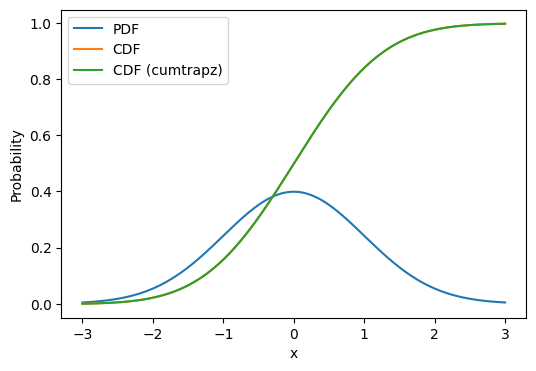

In [23]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot(x_values, pdf_values, label='PDF')
plt.plot(x_values, cdf_values_simps, label='CDF')
plt.plot(x_values, cdf_values_cumtrapz, label='CDF (cumtrapz)')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.show()
